<a href="https://colab.research.google.com/github/arathyjeevan/COVID-19/blob/master/wednesdaymdd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/facemask

/content/drive/My Drive/facemask


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [ ]:
print("[INFO] loading images...")
dataset='/content/drive/My Drive/facemask/face-mask-detector/dataset'
imagePaths = list(paths.list_images(dataset))

[INFO] loading images...


In [ ]:
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
 # extract the class label from the filename
 label = imagePath.split(os.path.sep)[-2]
 # load the input image (224x224) and preprocess it
 image = load_img(imagePath, target_size=(224, 224))
 image = img_to_array(image)
 image = preprocess_input(image)
 # update the data and labels lists, respectively
 data.append(image)
 labels.append(label)

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
 rotation_range=20,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
 input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
 layer.trainable = False

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [ ]:
print("[INFO] training head...")
H = model.fit(
 aug.flow(trainX, trainY, batch_size=BS),
 steps_per_epoch=len(trainX) // BS,
 validation_data=(testX, testY),
 validation_steps=len(testX) // BS,
 epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
34/34 [==============================] - 56s 2s/step - loss: 0.4990 - accuracy: 0.7837 - val_loss: 0.1195 - val_accuracy: 0.9746
Epoch 2/10
34/34 [==============================] - 56s 2s/step - loss: 0.1447 - accuracy: 0.9560 - val_loss: 0.0606 - val_accuracy: 0.9855
Epoch 3/10
34/34 [==============================] - 55s 2s/step - loss: 0.0897 - accuracy: 0.9757 - val_loss: 0.0413 - val_accuracy: 0.9855
Epoch 4/10
34/34 [==============================] - 55s 2s/step - loss: 0.0508 - accuracy: 0.9878 - val_loss: 0.0300 - val_accuracy: 0.9891
Epoch 5/10
34/34 [==============================] - 55s 2s/step - loss: 0.0458 - accuracy: 0.9888 - val_loss: 0.0209 - val_accuracy: 0.9964
Epoch 6/10
34/34 [==============================] - 55s 2s/step - loss: 0.0428 - accuracy: 0.9878 - val_loss: 0.0185 - val_accuracy: 0.9964
Epoch 7/10
34/34 [==============================] - 55s 2s/step - loss: 0.0384 - accuracy: 0.9888 - val_loss: 0.0187 - val_accuracy: 0.9

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
 target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



ValueError: ignored

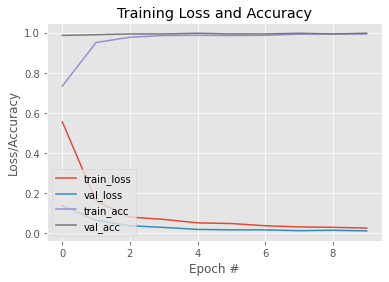

In [ ]:
from matplotlib.pyplot import *
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot)

In [ ]:
print("[INFO] saving mask detector model...")
model.save('mask-no-mask.h5')

[INFO] saving mask detector model...


In [ ]:
# install tensorflowjs 
!pip install tensorflowjs

     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 112kB 9.7MB/s 
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0


In [ ]:
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

In [ ]:
def keras2tfjs(model_path,dir_out):
 #import tensorflowjs as tfjs
 MODEL_PATH = model_path
 print('Model loading...')
 model=load_model(MODEL_PATH)
 #print('Model loaded. Started serving...')
 tfjs.converters.save_keras_model(model, dir_out)

In [ ]:
model_path='/content/drive/MyDrive/facemask/mask-no-mask.h5'
dir_out='/content/keras2js'
keras2tfjs(model_path,dir_out)

Model loading...


/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 6.8MB/s 


In [ ]:
pip install python_resize_image

In [ ]:
# import the necessary packages
from datetime import datetime
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img
import cv2
import os
from resizeimage import resizeimage

In [ ]:
model = load_model("/content/drive/MyDrive/facemask/mask-no-mask.h5")

In [69]:
from google.colab import files
files.upload()

Saving maskpic.jpg to maskpic.jpg


{'maskpic.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\x0e\x08\x08\x0e\x1e\x14\x11\x14\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\xff\xc2\x00\x11\x08\x04\x9c\x07\xd0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\xff\xc4\x00\x1a\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xfd\x06\x9e\x97\x05\xbb

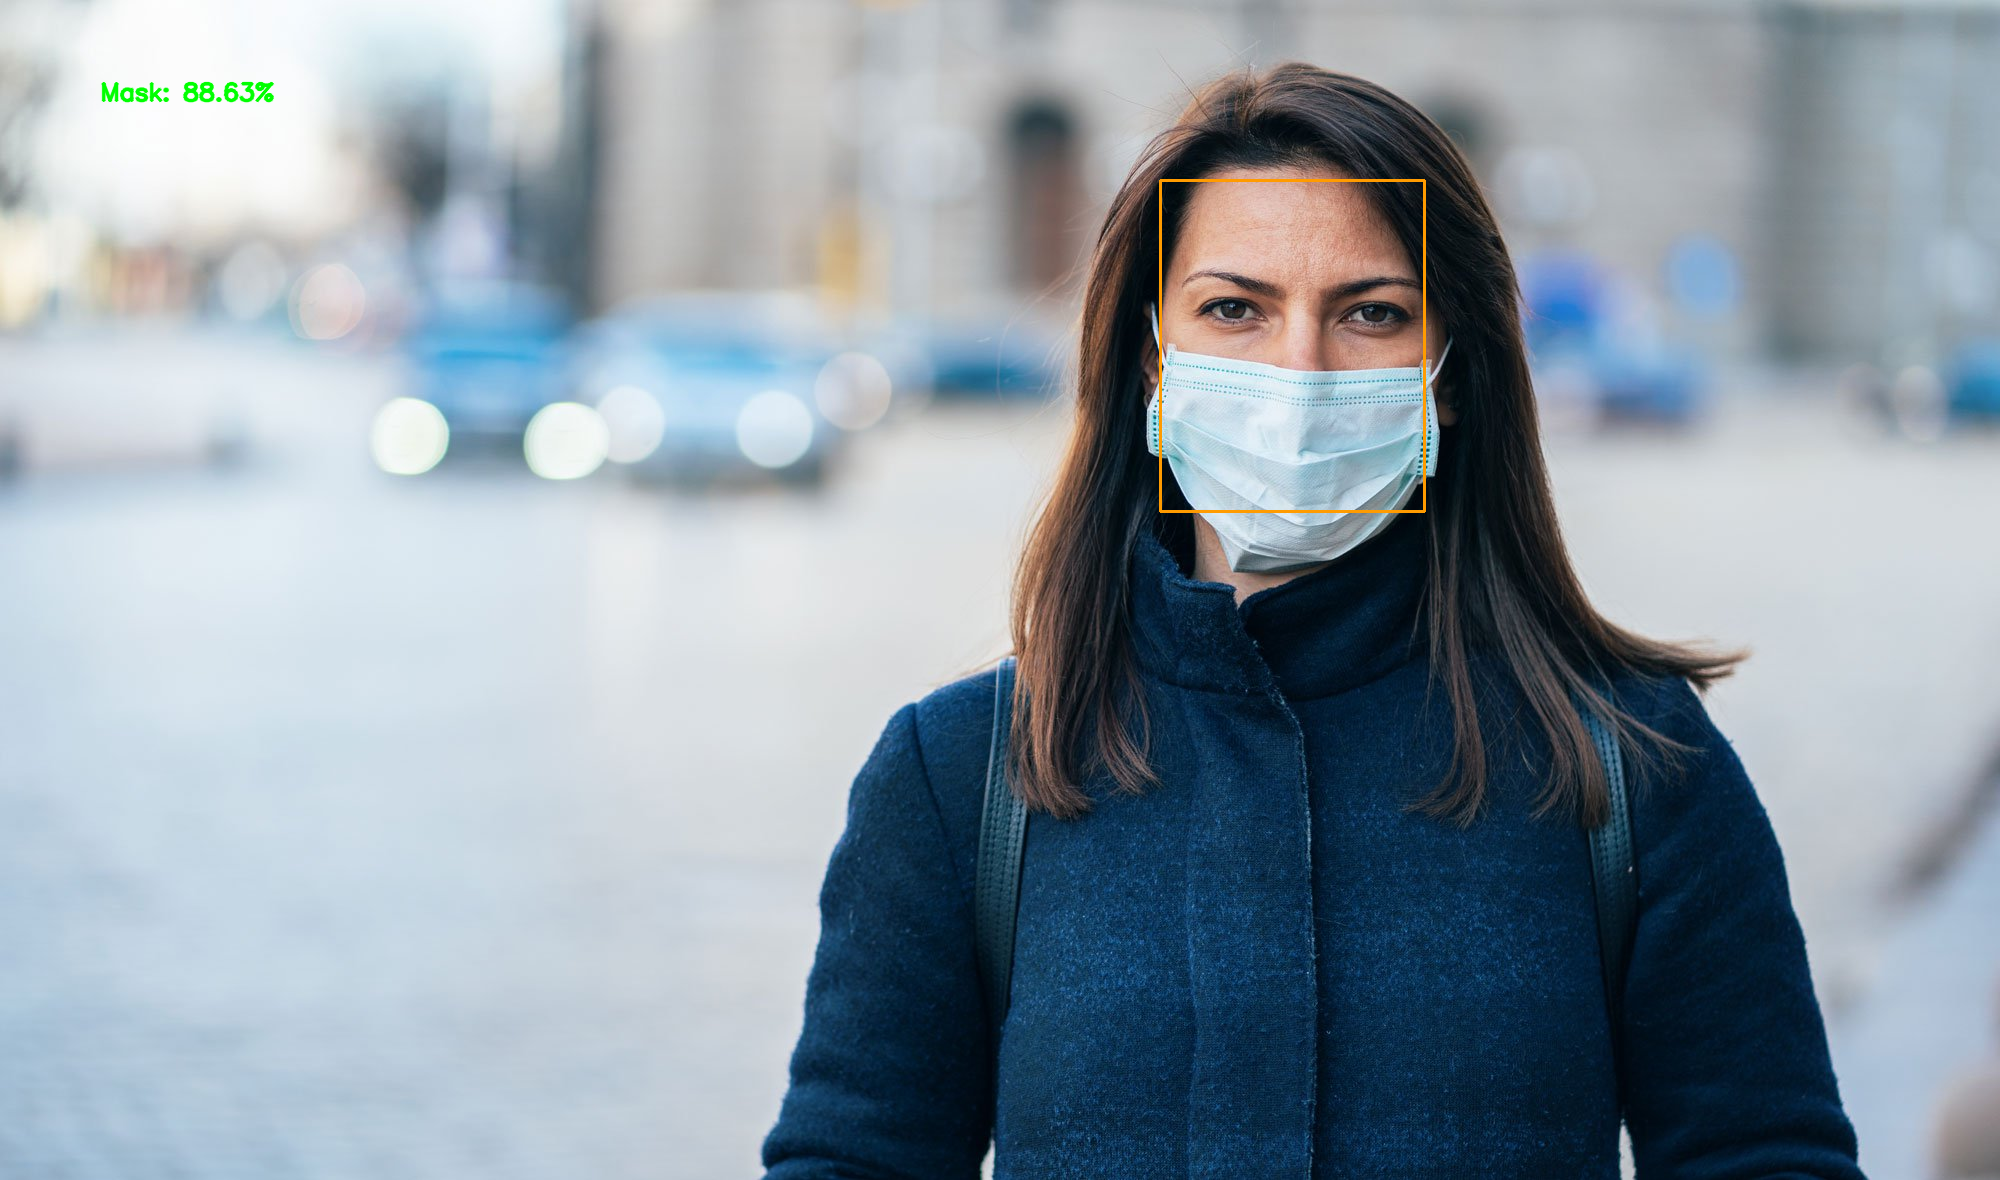

SyntaxError: ignored

In [83]:
detector = MTCNN()
video_path='/content/drive/MyDrive/facemask/maskpic.jpg'
frame = cv2.imread(video_path)
result = detector.detect_faces(frame)
if result != []:
 for person in result:
  bounding_box = person['box']
  keypoints = person['keypoints']
#print(result)
cv2.imwrite('opencv.png', frame)
image_file = load_img('opencv.png')
cover = resizeimage.resize_cover(image_file, [224, 224], validate=False)
x = []
x = img_to_array(cover)
face = preprocess_input(x)
face = np.expand_dims(face, axis=0)
 #x = np.expand_dims(x, axis=0)
(mask, withoutMask) = model.predict(face)[0]
 #print(pred[0][0])
label = "Mask" if mask > withoutMask else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 # include the probability in the label
label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
 #if pred[0][0]==0.0:
cv2.putText(frame,label,(100,100), font4, 0.8,(0,255,0),2,cv2.LINE_AA)
 #cv2.putText(frame, label, (startX, startY - 10),
 #cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
 #cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
 # elif pred[0][0]==1.0:
 # cv2.putText(frame,"ACCESS DENIED, No FACE-MASK",(100,100), font4, 0.8,(0,0,255),2,cv2.LINE_AA)
cv2.rectangle(frame,
(bounding_box[0], bounding_box[1]),(bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),(0,155,255),2) 
 #display resulting frame
#out.write(frame)
#display resulting frame
from google.colab.patches import cv2_imshow
cv2_imshow(frame)

if cv2.waitKey(10) &0xFF == ord('q'):
break

